In [1]:
import numpy as np
import pandas as pd
import json

In [2]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

# Parsing Helpers

In [3]:
def load_market_data(file, row_limit = None):
    md = pd.read_csv(file,sep=';')
    rename_columns = {'bid_price_1': 'bid', 'ask_price_1': 'ask', 'bid_volume_1': 'bid_sz', 'ask_volume_1': 'ask_sz'}
    md.rename(columns=rename_columns, inplace=True)
    if row_limit:
        markets = split_data_by_product(md.loc[md.timestamp <= row_limit])
    else:
        markets = split_data_by_product(md)
    symbols = list(markets.keys())
    print(f"Symbols: {symbols}")
    return markets

def split_data_by_product(df):
    markets = dict()
    df_grouped = df.groupby("product")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

In [4]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")
    empty_regex = re.compile(r"(\d+) ")
    
    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
            match = empty_regex.match(l)
            if match:
                trading_states.append(match.group(1))
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    order_depths = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": -1, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            extract_order_book(order_depths, state)
            
    positions = pd.DataFrame(positions)
    market_trades = pd.DataFrame(market_trades)
    if len(own_trades) == 0:
        own_trades.append({"timestamp": -1, "symbol": l, "price": np.nan, "quantity": 0, "buyer": "DUMMY", "seller": 0})
    own_trades = pd.DataFrame(own_trades)
    order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades, order_depths

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100 or t['timestamp'] == time:
                t['true_time'] = time-100 # Duplicates will be removed and first will be kept
                market_trades.append(t)

    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        quote = create_quote(time, sym, state['order_depths'][sym])
        order_depths.append(quote)
    return

def create_quote(time, sym, order_depths):
    quote = {'timestamp': time, 'symbol': sym}
    
    # Buy quotes
    quote['bid_levels'] = len(order_depths['buy_orders'])
    for i, px in enumerate(sorted(order_depths['buy_orders'], key=lambda x: float(x), reverse=True)):
        # Highest to lowest
        quote[f'bid_{i+1}'] = float(px)
        quote[f'bid_sz_{i+1}'] = order_depths["buy_orders"][px]
    for i in range(5, 1, -1):
        if f'bid_{i}' in quote:
            break
        else:
            quote[f'bid_{i}'] = np.nan
            quote[f'bid_sz_{i}'] = np.nan
    
    # Sell quotes
    quote['ask_levels'] = len(order_depths['sell_orders'])
    for i, px in enumerate(sorted(order_depths['sell_orders'], key=lambda x: float(x))):
        quote[f'ask_{i+1}'] = float(px)
        quote[f'ask_sz_{i+1}'] = np.abs(order_depths["sell_orders"][px])
    for i in range(5, 1, -1):
        if f'ask_{i}' in quote:
            break
        else:
            quote[f'ask_{i}'] = np.nan
            quote[f'ask_sz_{i}'] = np.nan
        
    return quote

def process_order_depths(order_depths):
    order_depths.rename(columns={'bid_1': 'bid', 'ask_1': 'ask', 'bid_sz_1': 'bid_sz', 'ask_sz_1': 'ask_sz'}, inplace=True)
    order_depths['mid_price'] = (order_depths['bid']+order_depths['ask'])/2
    nbbo = order_depths[['timestamp','symbol','bid','ask','bid_sz','ask_sz', 'mid_price']].copy()

    return nbbo

def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    market_trades.drop_duplicates(subset=['price', 'quantity', 'symbol', 'timestamp'], inplace=True)
    market_trades['timestamp'] = market_trades['true_time']
    market_trades.drop(columns=['true_time'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """    
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer'] else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    if len(sent_orders) == 0:
        return pd.DataFrame(columns = ['symbol', 'timestamp', 'price', 'quantity', 'side'])
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    df['side'] = df.apply(lambda x: np.sign(x['quantity']), axis=1)
    return df


def combine_quote_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
    trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
    trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum',
                                                                 'buy_vol':'sum','sell_vol':'sum','grey_vol':'sum'})
    trades_grouped['vwap'] = trades_grouped['notional']/trades_grouped['quantity']
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'}).drop(columns=['notional'])
    quote = quote.merge(trades_grouped.reset_index(), how='left')
    quote['volume'].fillna(0, inplace=True)
    for col in ['buy_vol', 'sell_vol','grey_vol', 'trades']:
        quote[col].fillna(0, inplace=True)
    
    quote.loc[quote.vwap.isna(), 'vwap'] = quote.loc[quote.vwap.isna(), 'mid_price']
    return quote


def combine_orders_fills(orders, fills):
    """ Combine orders sent with fills that the order got in the market
    """
    if orders.empty:
        return orders
    fills['active'] = fills.duplicated(subset=['symbol','timestamp','price', 'side'])
    fills['active_qty'] = fills['active']*fills['quantity']
    fills['passive_qty'] = (~fills['active'])*fills['quantity']

    fill_data = fills.groupby(['symbol','timestamp','price', 'side'])[['quantity','active_qty','passive_qty']].sum()
    fill_data.reset_index(inplace=True)
    fill_data.rename(columns={'quantity': 'fill_qty'}, inplace=True)
    orders = orders.merge(fill_data, how='left', on=['symbol','timestamp','price','side'])
    return orders


def load_data_from_log(file, by_symbol=True):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades, order_depths = process_trading_state_jsons(trading_states)
    quote = process_order_depths(order_depths)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    orders = process_sent_orders_json(sent_orders)
    
    # Joining actions to state
    market_trades = market_trades.merge(quote, how='left', on=['symbol','timestamp',])
    augment_trade_data(market_trades)
    
    own_trades = own_trades.merge(quote, how='left', on=['symbol','timestamp','symbol'])
    orders = orders.merge(quote, how='left', on=['symbol','timestamp'])
    orders = combine_orders_fills(orders, own_trades)
    quote = combine_quote_trades(quote, market_trades.copy())
    order_depths = combine_quote_trades(order_depths, market_trades.copy())
    
    dfs = {}
    dfs['orders'] = orders
    dfs['positions'] = positions
    dfs['quote'] = quote 
    dfs['order_depths'] = order_depths
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_trades
    
    if by_symbol:
        for table in dfs:
            dfs[table] = split_data_by_symbol(dfs[table])    
    return dfs


def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

# Experimental
def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(ask_dist - bid_dist)
    return

# Data Loading

In [5]:
file_name = "068803d5-0175-4576-8fd8-4d64894c54e2"
file_name = "baseline"

log_file = "logs/{}.log".format(file_name)
results_file = "results/{}.csv".format(file_name)

dfs = load_data_from_log(log_file)
results = load_market_data(results_file)
symbols = ['BANANAS', 'PEARLS']

Symbols: ['BANANAS', 'PEARLS']


In [6]:
trades = dfs['market_trades']['PEARLS'].copy()
quote_md = dfs['order_depths']['PEARLS'].copy()

In [7]:
quote_md

,timestamp,symbol,bid_levels,bid,bid_sz,bid_2,bid_sz_2,bid_5,bid_sz_5,bid_4,...,ask_sz_3,ask_2,ask_sz_2,mid_price,volume,buy_vol,sell_vol,grey_vol,vwap,trades
0,0,PEARLS,2,9998.0,1,9995.0,30.0,NaN,NaN,NaN,...,NaN,NaN,NaN,10001.5,0.0,0.0,0.0,0.0,10001.5,0.0
1,100,PEARLS,2,9996.0,1,9995.0,30.0,NaN,NaN,NaN,...,30.0,10004.0,1.0,9999.0,1.0,0.0,1.0,0.0,10002.0,1.0
2,200,PEARLS,2,9996.0,1,9995.0,21.0,NaN,NaN,NaN,...,NaN,10005.0,21.0,10000.0,0.0,0.0,0.0,0.0,10000.0,0.0
3,300,PEARLS,2,9996.0,2,9995.0,23.0,NaN,NaN,NaN,...,23.0,10004.0,2.0,9997.0,0.0,0.0,0.0,0.0,9997.0,0.0
4,400,PEARLS,3,9998.0,5,9996.0,2.0,NaN,NaN,NaN,...,NaN,10005.0,23.0,10001.0,3.0,0.0,3.0,0.0,9998.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,199500,PEARLS,2,9996.0,1,9995.0,21.0,NaN,NaN,NaN,...,21.0,10004.0,1.0,9997.0,4.0,4.0,0.0,0.0,10002.0,2.0
1995,199600,PEARLS,1,9995.0,28,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10000.0,0.0,0.0,0.0,0.0,10000.0,0.0
1996,199700,PEARLS,3,10002.0,1,9996.0,2.0,NaN,NaN,NaN,...,NaN,10005.0,28.0,10003.0,0.0,0.0,0.0,0.0,10003.0,0.0
1997,199800,PEARLS,2,9996.0,1,9995.0,27.0,NaN,NaN,NaN,...,NaN,10005.0,27.0,10000.0,1.0,1.0,0.0,0.0,10002.0,1.0


# Market Microstructure Analysis
- Spread Distribution
- Quote Size
- Notional
- Toxicity

In [88]:
def quote_weighted_px_full(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask
    size = quote.bid_sz + quote.ask_sz
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

def md_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
    for t in [5, 10, 25, 50, 100]:
        md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
        md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
    # quote weighted average price
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_wgt_px_top'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/quote_sz
    md['quote_wgt_px_3'] = md.apply(quote_weighted_px_full, levels=3, axis=1) 
    md['quote_wgt_px_full'] = md.apply(quote_weighted_px_full, axis=1)
    
    for t in [1, 2, 3, 4, 5, 10, 30, 100, 200]:
        # Price move since the past
        md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
        md[f'px_move_{t}'].fillna(0, inplace=True)
        
        # log return
        md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
        md[f'log_return_{t}'].fillna(1, inplace=True)
    # Volume    
    for t in [5, 10, 20, 30, 50]:
        md[f'volume_{t}'] = md['volume'].rolling(t, min_periods=0).sum()

    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    md['vol_imb'] = (md.buy_vol/(md.buy_vol+md.sell_vol)).fillna(0.5)
    
    
    ############# Future
    # Future prices
    for t in [1, 5, 10, 20, 30, 50, 100, 200]:
        # Future - present
        # Mid to mid, bid to mid, ask to mid
        md[f'fpx_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.mid_price
        md[f'fpx_bid_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.bid
        md[f'fpx_ask_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.ask
    for t in [1, 5, 10, 20, 30, 50, 100, 200]:
        md[f'fpx_move_{t}'] = np.sign(md[f'fpx_{t}'])
        md[f'fpx_bid_move_{t}'] = md[f'fpx_bid_{t}'] > 0
        md[f'fpx_ask_move_{t}'] = md[f'fpx_ask_{t}'] <= 0
    md['fvolume'] = md['volume'].shift(-1)
    for t in [5, 10, 20, 30, 50]:
        md[f'fvolume_{t}'] = md[f'volume_{t}'].shift(-t)
        
    # Features
    md['dist_fair_full'] = md['quote_wgt_px_full']-md['mid_price']
    md['dist_fair_3'] = md['quote_wgt_px_3']-md['mid_price']

    md['dist_fair_bid'] = md['quote_wgt_px_full']-md['bid'] # expected to be positive
    md['dist_fair_ask'] = md['quote_wgt_px_full']-md['ask'] # expected to be negative
    
    md['bid_improve'] = md['bid'] > md['bid'].shift(1)
    md['bid_revert'] = md['bid'] < md['bid'].shift(1)

    md['ask_improve'] = md['ask'] < md['ask'].shift(1)
    md['ask_revert'] = md['ask'] > md['ask'].shift(1)
    
    return

def high_level_summary(sym, quote):
    print(sym)
    summary = quote.agg({
        'spread':['mean','std'], 
        'mid_price': 'std', 
        'px_move_1':'mean',
        'volume':'sum',
        'trades':'sum',
        'bid_sz': 'mean', 
        'ask_sz':'mean', 
        'bid_sz_2': 'mean',
        'ask_sz_2': 'mean',
    })
    display(summary)

In [9]:
mid_labels = []
bid_labels = []
ask_labels = []
px_delta_cols = []

for t in [1, 5, 10, 20, 30, 50, 100, 200]:
    px_delta_cols.append(f'fpx_{t}')
    mid_labels.append(f'fpx_move_{t}')
    bid_labels.append(f'fpx_bid_move_{t}')
    ask_labels.append(f'fpx_ask_move_{t}')

## Bananas

In [89]:
sym = symbols[0]
print(sym)
quote = dfs['order_depths'][sym].copy()
md_preprocess(quote)

BANANAS


In [90]:
quote

,timestamp,symbol,bid_levels,bid,bid_sz,bid_2,bid_sz_2,bid_5,bid_sz_5,bid_4,...,fvolume_30,fvolume_50,dist_fair_full,dist_fair_3,dist_fair_bid,dist_fair_ask,bid_improve,bid_revert,ask_improve,ask_revert
0,0,BANANAS,2,4946.0,1,4945.0,30.0,NaN,NaN,NaN,...,37.0,65.0,-0.540984,-0.540984,2.459016,-3.540984,False,False,False,False
1,100,BANANAS,1,4945.0,31,NaN,NaN,NaN,NaN,NaN,...,38.0,66.0,1.152174,1.152174,3.652174,-1.347826,False,True,True,False
2,200,BANANAS,1,4945.0,22,NaN,NaN,NaN,NaN,NaN,...,38.0,66.0,0.477273,0.477273,3.477273,-2.522727,False,False,False,True
3,300,BANANAS,1,4945.0,25,NaN,NaN,NaN,NaN,NaN,...,38.0,66.0,0.000000,0.000000,3.500000,-3.500000,False,False,False,True
4,400,BANANAS,2,4946.0,5,4945.0,25.0,NaN,NaN,NaN,...,38.0,66.0,-0.727273,-0.727273,2.272727,-3.727273,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,199500,BANANAS,1,4930.0,22,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,3.500000,-3.500000,False,False,False,False
1995,199600,BANANAS,1,4930.0,28,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,3.500000,-3.500000,False,False,False,False
1996,199700,BANANAS,1,4931.0,30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.466667,0.466667,3.466667,-2.533333,True,False,False,False
1997,199800,BANANAS,2,4931.0,1,4930.0,27.0,NaN,NaN,NaN,...,NaN,NaN,-0.482143,-0.482143,2.517857,-3.482143,False,False,False,False


In [59]:
print(quote.columns)

Index(['timestamp', 'symbol', 'bid_levels', 'bid', 'bid_sz', 'bid_2',
       'bid_sz_2', 'bid_5', 'bid_sz_5', 'bid_4',
       ...
       'fpx_ask_move_200', 'fvolume_5', 'fvolume_10', 'fvolume_20',
       'fvolume_30', 'fvolume_50', 'dist_fair_full', 'dist_fair_3',
       'dist_fair_bid', 'dist_fair_ask'],
      dtype='object', length=129)


In [12]:
high_level_summary(sym, quote)

BANANAS


,spread,mid_price,px_move_1,volume,trades,bid_sz,ask_sz,bid_sz_2,ask_sz_2
mean,5.308154,NaN,-0.008754,NaN,NaN,17.551276,17.782391,23.063946,21.993046
std,1.897812,7.960266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,1329.0,520.0,NaN,NaN,NaN,NaN


### Orderbook Analysis

In [13]:
pd.merge(left = quote.groupby('bid_levels').size().rename('counts_bid'), 
         right = quote.groupby('ask_levels').size().rename('counts_ask'), 
         left_index=True, right_index=True)

,counts_bid,counts_ask
bid_levels,,
1,1264,1280
2,656,610
3,73,107
4,6,2


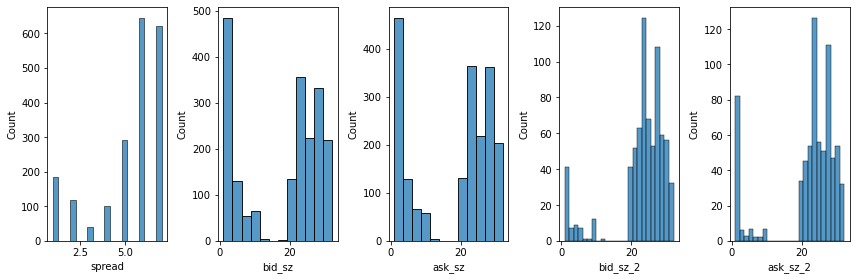

In [14]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['spread','bid_sz','ask_sz', 'bid_sz_2','ask_sz_2']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

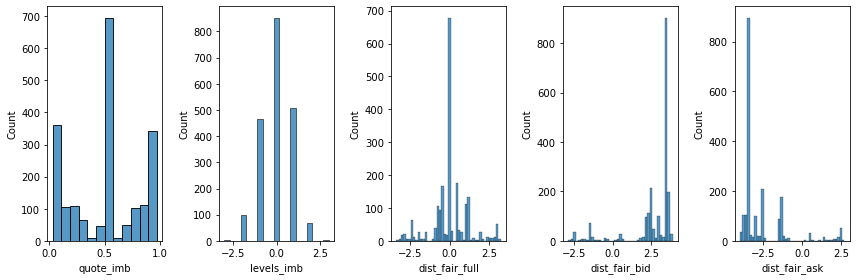

In [15]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['quote_imb','levels_imb', 'dist_fair_full','dist_fair_bid','dist_fair_ask']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

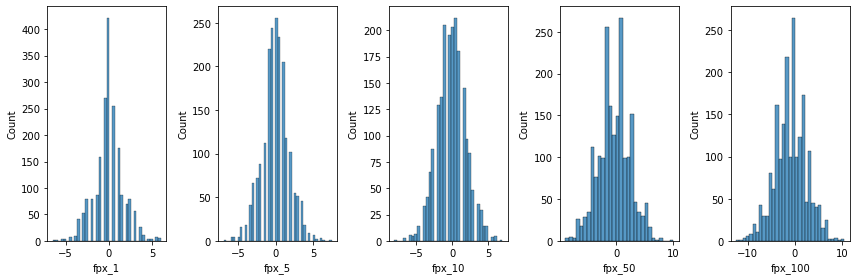

In [16]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['fpx_1','fpx_5','fpx_10','fpx_50','fpx_100']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

In [17]:
# sub_data = quote.loc[np.abs(quote.dist_fair_full) > 1].copy()
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_full', 'dist_fair_3'] + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1999 1999 100.00%


,quote_imb,levels_imb,dist_fair_full,dist_fair_3,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100,fpx_move_200
quote_imb,1.000,-0.897,0.736,0.734,0.374,0.318,0.304,0.225,0.220,0.182,0.186,0.156
levels_imb,-0.897,1.000,-0.826,-0.810,-0.438,-0.368,-0.341,-0.274,-0.247,-0.214,-0.208,-0.171
dist_fair_full,0.736,-0.826,1.000,0.992,0.534,0.464,0.433,0.380,0.340,0.284,0.257,0.221
dist_fair_3,0.734,-0.810,0.992,1.000,0.534,0.460,0.432,0.378,0.340,0.279,0.254,0.216
fpx_move_1,0.374,-0.438,0.534,0.534,1.000,0.382,0.312,0.273,0.254,0.202,0.173,0.132
fpx_move_5,0.318,-0.368,0.464,0.460,0.382,1.000,0.422,0.346,0.280,0.235,0.186,0.155
fpx_move_10,0.304,-0.341,0.433,0.432,0.312,0.422,1.000,0.432,0.390,0.311,0.258,0.214
fpx_move_20,0.225,-0.274,0.380,0.378,0.273,0.346,0.432,1.000,0.493,0.385,0.292,0.256
fpx_move_30,0.220,-0.247,0.340,0.340,0.254,0.280,0.390,0.493,1.000,0.521,0.343,0.293
fpx_move_50,0.182,-0.214,0.284,0.279,0.202,0.235,0.311,0.385,0.521,1.000,0.433,0.335


In [18]:
sub_data = quote.loc[np.abs(quote.volume) > 2].copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_full', 'dist_fair_3'] + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1999 109 5.45%


,quote_imb,levels_imb,dist_fair_full,dist_fair_3,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100,fpx_move_200
quote_imb,1.000,-0.905,0.684,0.675,0.406,0.334,0.349,0.149,0.267,0.189,0.192,0.212
levels_imb,-0.905,1.000,-0.811,-0.768,-0.453,-0.396,-0.389,-0.184,-0.309,-0.223,-0.244,-0.257
dist_fair_full,0.684,-0.811,1.000,0.982,0.544,0.521,0.470,0.399,0.421,0.331,0.267,0.389
dist_fair_3,0.675,-0.768,0.982,1.000,0.555,0.513,0.463,0.408,0.412,0.320,0.250,0.376
fpx_move_1,0.406,-0.453,0.544,0.555,1.000,0.476,0.334,0.292,0.310,0.204,0.263,0.215
fpx_move_5,0.334,-0.396,0.521,0.513,0.476,1.000,0.559,0.455,0.340,0.315,0.260,0.273
fpx_move_10,0.349,-0.389,0.470,0.463,0.334,0.559,1.000,0.460,0.504,0.319,0.163,0.293
fpx_move_20,0.149,-0.184,0.399,0.408,0.292,0.455,0.460,1.000,0.491,0.280,0.304,0.297
fpx_move_30,0.267,-0.309,0.421,0.412,0.310,0.340,0.504,0.491,1.000,0.428,0.182,0.283
fpx_move_50,0.189,-0.223,0.331,0.320,0.204,0.315,0.319,0.280,0.428,1.000,0.307,0.299


In [70]:
# Very little correlation between spread and past volume
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['spread', 'fvolume', 'fvolume_5', 'fvolume_10', 'fvolume_20',
       'fvolume_30', 'fvolume_50']].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1999 1999 100.00%


,spread,fvolume,fvolume_5,fvolume_10,fvolume_20,fvolume_30,fvolume_50
spread,1.000,-0.132,-0.035,-0.020,-0.032,-0.030,0.009
fvolume,-0.132,1.000,0.441,0.332,0.237,0.196,0.157
fvolume_5,-0.035,0.441,1.000,0.710,0.525,0.449,0.347
fvolume_10,-0.020,0.332,0.710,1.000,0.735,0.627,0.487
fvolume_20,-0.032,0.237,0.525,0.735,1.000,0.850,0.668
fvolume_30,-0.030,0.196,0.449,0.627,0.850,1.000,0.811
fvolume_50,0.009,0.157,0.347,0.487,0.668,0.811,1.000


### Quote Change Analysis

In [77]:
quote_cols = ['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'bid_sz_2','ask_sz_2',
              'dist_fair_bid','dist_fair_ask', 'volume']

In [79]:
quote[quote_cols+px_delta_cols[:3]].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_bid,dist_fair_ask,volume,fpx_1,fpx_5,fpx_10
count,1999.00,1999.00,1999.00,1999.00,1999.00,735.00,719.00,1999.00,1999.00,1999.00,1999.00,1999.00,1999.00
mean,1.41,1.42,-0.01,17.55,17.78,23.06,21.99,2.67,-2.64,0.66,-0.01,-0.04,-0.08
std,0.58,0.60,0.92,11.30,11.19,7.45,8.75,1.50,1.50,2.20,1.68,1.83,2.00
min,1.00,1.00,-3.00,1.00,1.00,1.00,1.00,-2.89,-4.00,0.00,-6.50,-7.00,-8.00
25%,1.00,1.00,-1.00,4.00,4.00,22.00,21.00,2.45,-3.50,0.00,-1.00,-1.00,-1.50
50%,1.00,1.00,0.00,23.00,23.00,25.00,24.00,3.47,-3.46,0.00,0.00,0.00,0.00
75%,2.00,2.00,1.00,27.00,27.00,28.00,27.00,3.50,-2.52,0.00,1.00,1.00,1.00
max,4.00,4.00,3.00,32.00,32.00,32.00,32.00,3.89,2.72,22.00,6.00,7.50,7.00


In [80]:
quote.loc[quote.bid_improve][quote_cols+px_delta_cols].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_bid,dist_fair_ask,volume,fpx_1,fpx_5,fpx_10,fpx_20,fpx_30,fpx_50,fpx_100,fpx_200
count,543.00,543.00,543.00,543.00,543.00,432.00,166.00,543.00,543.00,543.00,543.00,543.00,543.00,543.00,543.00,543.00,543.00,543.00
mean,1.94,1.34,0.59,7.93,18.83,21.98,22.50,1.22,-2.99,0.62,-0.89,-0.95,-1.08,-1.11,-1.16,-1.30,-1.82,-2.61
std,0.60,0.55,0.95,9.57,10.91,8.65,8.24,2.05,1.03,2.18,1.80,1.96,2.08,2.24,2.42,2.78,3.46,4.12
min,1.00,1.00,-2.00,1.00,1.00,1.00,1.00,-2.89,-4.00,0.00,-6.50,-7.00,-8.00,-7.50,-8.50,-8.50,-12.50,-15.50
25%,2.00,1.00,0.00,1.00,5.50,21.00,22.00,-1.27,-3.53,0.00,-2.00,-2.50,-2.50,-2.50,-3.00,-3.00,-4.00,-5.50
50%,2.00,1.00,1.00,3.00,23.00,24.00,24.00,2.22,-3.45,0.00,-0.50,-1.00,-1.00,-1.00,-1.00,-1.50,-2.00,-2.50
75%,2.00,2.00,1.00,10.00,27.00,28.00,27.75,2.54,-2.62,0.00,0.00,0.50,0.50,0.50,0.50,0.50,0.50,0.50
max,4.00,3.00,3.00,32.00,32.00,32.00,31.00,3.70,2.46,20.00,5.50,6.00,6.00,6.00,5.50,6.50,7.00,8.00


In [81]:
quote.loc[quote.bid_revert][quote_cols+px_delta_cols].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_bid,dist_fair_ask,volume,fpx_1,fpx_5,fpx_10,fpx_20,fpx_30,fpx_50,fpx_100,fpx_200
count,562.00,562.00,562.00,562.00,562.00,91.00,208.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00
mean,1.17,1.43,-0.26,22.09,17.61,24.67,22.01,3.27,-2.43,0.78,0.43,0.35,0.34,0.38,0.28,0.09,-0.28,-1.17
std,0.39,0.60,0.76,8.79,11.23,5.14,8.35,0.64,1.76,2.24,1.57,1.81,1.85,2.20,2.36,2.76,3.25,4.16
min,1.00,1.00,-3.00,1.00,1.00,2.00,1.00,-1.47,-3.85,0.00,-3.50,-5.00,-5.00,-7.00,-6.00,-9.00,-10.00,-12.00
25%,1.00,1.00,-1.00,21.00,4.00,22.00,21.00,3.45,-3.50,0.00,-0.50,-1.00,-1.00,-1.00,-1.50,-2.00,-2.50,-4.00
50%,1.00,1.00,0.00,25.00,23.00,25.00,24.00,3.50,-3.50,0.00,0.00,0.50,0.00,0.50,0.50,0.00,-0.50,-1.00
75%,1.00,2.00,0.00,28.00,27.00,28.00,27.00,3.50,-1.44,1.00,1.00,1.50,1.50,2.00,1.50,1.88,2.00,2.00
max,3.00,4.00,2.00,32.00,32.00,32.00,32.00,3.78,2.70,22.00,6.00,7.50,7.00,6.50,7.50,10.00,10.50,10.50


## Pearls

In [82]:
sym = symbols[1]
print(sym)
quote = dfs['order_depths'][sym].copy()
md_preprocess(quote)

PEARLS


In [62]:
print(quote.columns)

Index(['timestamp', 'symbol', 'bid_levels', 'bid', 'bid_sz', 'bid_2',
       'bid_sz_2', 'bid_5', 'bid_sz_5', 'bid_4',
       ...
       'fpx_ask_move_200', 'fvolume_5', 'fvolume_10', 'fvolume_20',
       'fvolume_30', 'fvolume_50', 'dist_fair_full', 'dist_fair_3',
       'dist_fair_bid', 'dist_fair_ask'],
      dtype='object', length=129)


In [27]:
high_level_summary(sym, quote)

PEARLS


,spread,mid_price,px_move_1,volume,trades,bid_sz,ask_sz,bid_sz_2,ask_sz_2
mean,6.817409,NaN,0.0,NaN,NaN,8.34067,8.606803,19.82337,19.298077
std,2.466832,1.4938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,917.0,480.0,NaN,NaN,NaN,NaN


### Orderbook Analysis

In [28]:
pd.merge(left = quote.groupby('bid_levels').size().rename('counts_bid'), 
         right = quote.groupby('ask_levels').size().rename('counts_ask'), 
         left_index=True, right_index=True)

,counts_bid,counts_ask
bid_levels,,
1,527,543
2,1142,1100
3,304,331
4,25,23
5,1,2


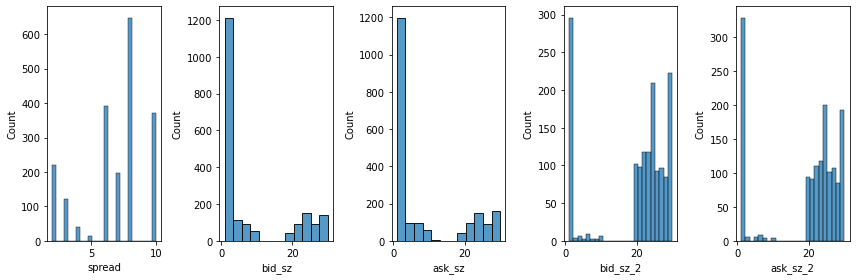

In [29]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['spread','bid_sz','ask_sz', 'bid_sz_2','ask_sz_2']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

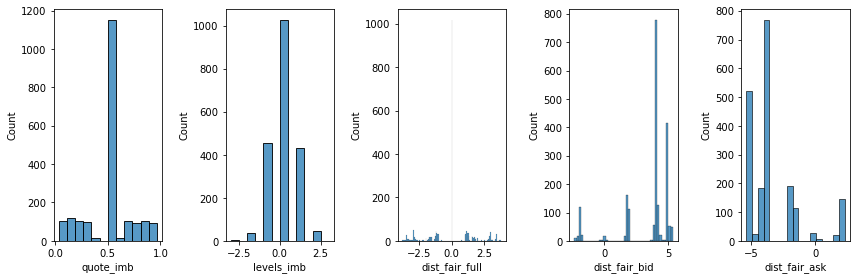

In [30]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['quote_imb','levels_imb', 'dist_fair_full','dist_fair_bid','dist_fair_ask']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

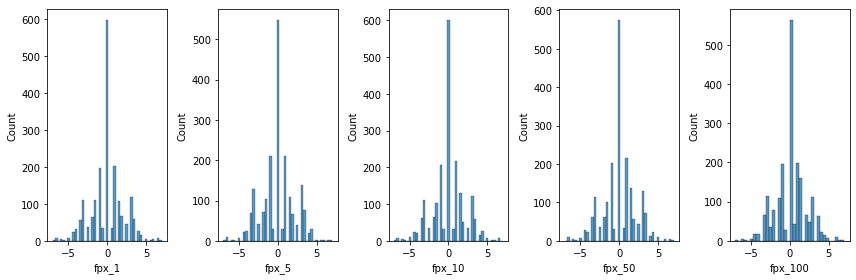

In [31]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['fpx_1','fpx_5','fpx_10','fpx_50','fpx_100']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

In [32]:
# sub_data = quote.loc[np.abs(quote.dist_fair_full) > 1].copy()
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_full', 'dist_fair_3'] + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1999 1999 100.00%


,quote_imb,levels_imb,dist_fair_full,dist_fair_3,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100,fpx_move_200
quote_imb,1.000,-0.069,0.225,0.253,0.092,0.090,0.132,0.084,0.084,0.118,0.118,0.130
levels_imb,-0.069,1.000,-0.924,-0.807,-0.614,-0.613,-0.600,-0.627,-0.627,-0.605,-0.582,-0.558
dist_fair_full,0.225,-0.924,1.000,0.931,0.614,0.623,0.607,0.628,0.629,0.613,0.595,0.583
dist_fair_3,0.253,-0.807,0.931,1.000,0.579,0.584,0.572,0.592,0.591,0.578,0.564,0.547
fpx_move_1,0.092,-0.614,0.614,0.579,1.000,0.414,0.395,0.433,0.438,0.410,0.388,0.375
fpx_move_5,0.090,-0.613,0.623,0.584,0.414,1.000,0.375,0.424,0.424,0.396,0.374,0.361
fpx_move_10,0.132,-0.600,0.607,0.572,0.395,0.375,1.000,0.426,0.401,0.384,0.374,0.383
fpx_move_20,0.084,-0.627,0.628,0.592,0.433,0.424,0.426,1.000,0.442,0.404,0.406,0.384
fpx_move_30,0.084,-0.627,0.629,0.591,0.438,0.424,0.401,0.442,1.000,0.409,0.404,0.410
fpx_move_50,0.118,-0.605,0.613,0.578,0.410,0.396,0.384,0.404,0.409,1.000,0.415,0.422


In [33]:
sub_data = quote.loc[np.abs(quote.volume) > 2].copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_full', 'dist_fair_3'] + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1999 89 4.45%


,quote_imb,levels_imb,dist_fair_full,dist_fair_3,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100,fpx_move_200
quote_imb,1.000,-0.002,0.264,0.270,0.088,0.142,0.093,0.146,0.032,0.108,0.049,0.136
levels_imb,-0.002,1.000,-0.912,-0.868,-0.653,-0.613,-0.701,-0.728,-0.687,-0.600,-0.731,-0.663
dist_fair_full,0.264,-0.912,1.000,0.973,0.669,0.621,0.688,0.715,0.667,0.633,0.727,0.661
dist_fair_3,0.270,-0.868,0.973,1.000,0.656,0.602,0.675,0.702,0.650,0.616,0.740,0.645
fpx_move_1,0.088,-0.653,0.669,0.656,1.000,0.376,0.459,0.491,0.529,0.465,0.449,0.361
fpx_move_5,0.142,-0.613,0.621,0.602,0.376,1.000,0.452,0.432,0.385,0.488,0.625,0.523
fpx_move_10,0.093,-0.701,0.688,0.675,0.459,0.452,1.000,0.561,0.449,0.458,0.561,0.521
fpx_move_20,0.146,-0.728,0.715,0.702,0.491,0.432,0.561,1.000,0.534,0.463,0.607,0.474
fpx_move_30,0.032,-0.687,0.667,0.650,0.529,0.385,0.449,0.534,1.000,0.516,0.578,0.550
fpx_move_50,0.108,-0.600,0.633,0.616,0.465,0.488,0.458,0.463,0.516,1.000,0.422,0.609


In [72]:
# Very little correlation between spread and past volume
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['spread', 'fvolume', 'fvolume_5', 'fvolume_10', 'fvolume_20',
       'fvolume_30', 'fvolume_50']].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1999 1999 100.00%


,spread,fvolume,fvolume_5,fvolume_10,fvolume_20,fvolume_30,fvolume_50
spread,1.000,-0.152,-0.079,-0.057,-0.057,-0.028,-0.054
fvolume,-0.152,1.000,0.444,0.316,0.225,0.163,0.147
fvolume_5,-0.079,0.444,1.000,0.703,0.504,0.382,0.333
fvolume_10,-0.057,0.316,0.703,1.000,0.710,0.547,0.464
fvolume_20,-0.057,0.225,0.504,0.710,1.000,0.808,0.634
fvolume_30,-0.028,0.163,0.382,0.547,0.808,1.000,0.762
fvolume_50,-0.054,0.147,0.333,0.464,0.634,0.762,1.000


### Quote Change Analysis
- What happens to the quote when price improves?
- What happens to the quote when a level is taken out?

In [83]:
quote_cols = ['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'bid_sz_2','ask_sz_2',
              'dist_fair_bid','dist_fair_ask', 'volume']

In [85]:
quote[quote_cols+px_delta_cols[:3]].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_bid,dist_fair_ask,volume,fpx_1,fpx_5,fpx_10
count,1999.00,1999.00,1999.00,1999.00,1999.00,1472.00,1456.00,1999.00,1999.00,1999.00,1999.00,1999.00,1999.00
mean,1.91,1.92,-0.01,8.34,8.61,19.82,19.30,3.42,-3.40,0.46,0.00,0.00,0.01
std,0.68,0.70,0.79,10.25,10.40,10.01,10.32,1.95,1.96,1.32,2.12,2.13,2.09
min,1.00,1.00,-3.00,1.00,1.00,1.00,1.00,-2.34,-5.40,0.00,-7.00,-7.00,-7.00
25%,1.00,1.00,0.00,1.00,1.00,20.00,20.00,3.84,-4.96,0.00,-1.00,-1.00,-1.00
50%,2.00,2.00,0.00,2.00,2.00,23.00,23.00,4.00,-4.00,0.00,0.00,0.00,0.00
75%,2.00,2.00,0.00,20.00,20.50,27.00,27.00,4.95,-1.97,0.00,1.00,1.00,1.00
max,5.00,5.00,3.00,30.00,30.00,30.00,30.00,5.36,2.29,13.00,7.00,7.00,7.00


In [86]:
quote.loc[quote.bid_improve][quote_cols+px_delta_cols].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_bid,dist_fair_ask,volume,fpx_1,fpx_5,fpx_10,fpx_20,fpx_30,fpx_50,fpx_100,fpx_200
count,673.00,673.00,673.00,673.00,673.00,673.00,528.00,673.00,673.00,673.00,673.00,673.00,673.0,673.00,673.00,673.00,673.00,673.00
mean,2.44,1.95,0.50,3.04,6.95,15.78,20.47,1.80,-3.72,0.47,-0.93,-0.96,-0.9,-0.89,-0.92,-1.04,-0.85,-0.81
std,0.57,0.63,0.85,2.60,9.62,11.60,9.69,2.31,1.60,1.39,2.25,2.21,2.2,2.31,2.29,2.14,2.15,2.27
min,2.00,1.00,-2.00,1.00,1.00,1.00,1.00,-2.34,-5.40,0.00,-7.00,-7.00,-7.0,-6.50,-7.00,-7.00,-7.00,-7.00
25%,2.00,2.00,0.00,1.00,1.00,2.00,20.00,0.00,-4.27,0.00,-2.50,-2.50,-2.5,-2.50,-2.50,-2.50,-2.50,-2.50
50%,2.00,2.00,1.00,2.00,2.00,21.00,24.00,1.89,-4.00,0.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00
75%,3.00,2.00,1.00,4.00,7.00,26.00,27.00,4.00,-3.96,0.00,0.00,0.00,0.0,0.50,0.00,0.00,0.00,0.50
max,5.00,4.00,3.00,12.00,30.00,30.00,30.00,4.33,2.16,13.00,6.00,4.50,6.5,6.00,6.50,6.50,6.50,6.50


In [87]:
quote.loc[quote.bid_revert][quote_cols+px_delta_cols].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_bid,dist_fair_ask,volume,fpx_1,fpx_5,fpx_10,fpx_20,fpx_30,fpx_50,fpx_100,fpx_200
count,676.00,676.00,676.00,676.00,676.00,268.00,382.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00
mean,1.43,1.73,-0.30,15.87,12.73,23.18,18.55,4.54,-3.29,0.50,0.60,0.56,0.61,0.55,0.61,0.66,0.71,0.68
std,0.55,0.73,0.57,11.67,11.44,7.03,10.61,0.75,2.25,1.28,1.87,1.90,1.90,1.92,1.85,1.85,1.84,1.79
min,1.00,1.00,-2.00,1.00,1.00,1.00,1.00,0.00,-5.37,0.00,-5.00,-4.50,-5.00,-4.50,-5.00,-4.00,-3.50,-4.00
25%,1.00,1.00,-1.00,2.00,2.00,22.00,2.25,4.00,-5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,2.00,0.00,21.50,7.00,24.00,23.00,5.00,-4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2.00,2.00,0.00,26.00,24.00,27.25,26.00,5.00,-1.86,0.00,1.50,1.50,1.50,1.50,1.50,1.50,1.50,1.50
max,3.00,4.00,1.00,30.00,30.00,30.00,30.00,5.36,2.29,12.00,7.00,7.00,7.00,7.00,6.00,7.00,7.00,7.00


## Pearls Price Cross Analysis
- What does the quote look like when bid/ask cross 10K?

In [40]:
sym = symbols[1]
print(sym)
quote = dfs['order_depths'][sym].copy()
md_preprocess(quote)

PEARLS


In [41]:
bid_cross = quote.loc[quote.bid >= 10000].copy()
ask_cross = quote.loc[quote.ask <= 10000].copy()

In [42]:
quote[['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'dist_fair_bid','dist_fair_ask']].describe()

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,dist_fair_bid,dist_fair_ask
count,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,1.914957,1.919960,-0.005003,8.340670,8.606803,3.416663,-3.400746
std,0.680613,0.697196,0.785233,10.252737,10.404361,1.952227,1.964328
min,1.000000,1.000000,-3.000000,1.000000,1.000000,-2.339623,-5.400000
25%,1.000000,1.000000,0.000000,1.000000,1.000000,3.841110,-4.963636
50%,2.000000,2.000000,0.000000,2.000000,2.000000,4.000000,-4.000000
75%,2.000000,2.000000,0.000000,20.000000,20.500000,4.954522,-1.968254
max,5.000000,5.000000,3.000000,30.000000,30.000000,5.357143,2.285714


In [43]:
ask_cross[['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'dist_fair_bid','dist_fair_ask']].describe()

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,dist_fair_bid,dist_fair_ask
count,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.700000,2.86500,-1.165000,9.050000,2.635000,4.218377,1.603377
std,0.511182,0.63939,0.467835,10.928157,2.439576,0.640028,0.747182
min,1.000000,2.00000,-3.000000,1.000000,1.000000,1.750000,-0.250000
25%,1.000000,2.00000,-1.000000,1.000000,1.000000,3.953488,1.825706
50%,2.000000,3.00000,-1.000000,2.000000,1.000000,4.000000,1.953488
75%,2.000000,3.00000,-1.000000,21.250000,4.000000,4.910079,1.962607
max,3.000000,5.00000,0.000000,30.000000,13.000000,5.285714,2.285714


In [44]:
bid_cross[['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'dist_fair_bid','dist_fair_ask']].describe()

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,dist_fair_bid,dist_fair_ask
count,195.000000,195.00000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,2.871795,1.65641,1.215385,2.815385,9.943590,-1.659793,-4.270050
std,0.633249,0.49731,0.470544,2.436147,11.360626,0.697459,0.617972
min,2.000000,1.00000,0.000000,1.000000,1.000000,-2.339623,-5.312500
25%,2.000000,1.00000,1.000000,1.000000,1.000000,-1.964912,-4.922619
50%,3.000000,2.00000,1.000000,1.000000,2.000000,-1.955556,-4.000000
75%,3.000000,2.00000,1.000000,4.000000,23.000000,-1.818182,-3.957447
max,5.000000,3.00000,3.000000,12.000000,30.000000,0.327273,-1.672727


# Intraday Plotting

In [45]:
fig_size = (6,3)
def plot_quote(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", "bid", data=md, color="red")
    ax.plot("timestamp", "ask", data=md, color="blue")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (Seashells)")
    ax.set_title(sym)
    return
    
def plot_cum_volume(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    data = md['volume'].cumsum()
    ax.plot(data, linestyle='-.')
    ax.set_xlabel("Time")
    ax.set_ylabel("Volume")
    ax.set_title(sym)
    return
    
def plot_spread(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", "spread", data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel("Spread")
    ax.set_title(sym)
    return

def plot_price(md, sym, price_type):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", price_type, data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel(price_type.capitalize())
    ax.set_title(sym)
    return

def plot_ohcl(md, sym):
    # Candlestick plot
    pass

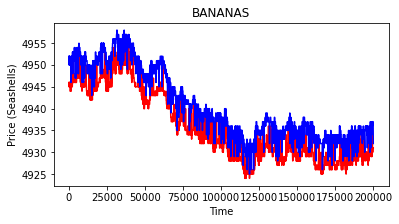

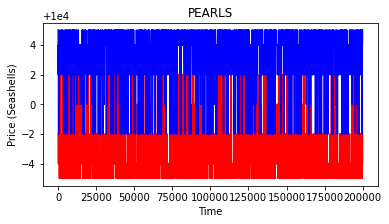

In [46]:
for s in symbols:
    plot_quote(dfs['quote'][s], s)
    # plot_price(markets[s], s, "mid_px_mavg10")

# Regression

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
sym = symbols[0]
print(sym)
quote = dfs['order_depths'][sym].copy()
md_preprocess(quote)

BANANAS


In [49]:
features = ['dist_fair_full']
labels = []
for t in [1, 5, 10, 20, 30, 50, 100]:
    labels.append(f'fpx_move_{t}')

In [50]:
total_samples = len(quote)

In [51]:
train_samples = total_samples//4

train_data = quote.iloc[:train_samples][features+labels]
X_train = train_data[features].values
clfs = {}


for t in [1, 5, 10, 20, 30, 50, 100]:
    y_train = train_data[f'fpx_move_{t}'].values
    clfs[t] = LogisticRegression(random_state=0).fit(X_train, y_train)

In [52]:
for t in [50]:
    probs = clfs[t].predict_proba(X_train)
    train_data[f'predict_{t}'] = clfs[t].classes_[probs.argmax(axis=1)]
    train_data[f'predict_prob_{t}'] = probs.max(axis=1)
    # print(clfs[t].score(X_train, y_train[t]))

In [53]:
train_data['correct'] = train_data['predict_50'] == train_data['fpx_move_50']

In [54]:
train_data['correct'].mean()

0.561122244488978

In [55]:
train_data.loc[train_data['predict_prob_50'] > 0.65]['correct'].mean()

0.75

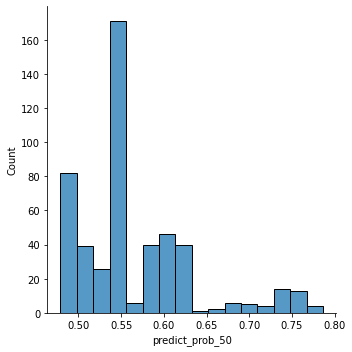

In [56]:
sns.displot(train_data['predict_prob_50'])